# COVIDcast Data Smoothing
In this document, we compare different methods of smoothing COVIDcast signals. See the associated README.md file for the mathematical description of the methods.

## An Example: California Google Health Trends
To begin, let's look at an example signal, say the Google Health Trends search activity. We will look at the raw existing data, the smoothed data, and then describe the existing smoother.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import covidcast
from datetime import date

from delphi_utils import (
    left_gauss_linear_smoother,
    moving_window_smoother,
    causal_savgol_smoother,
    impute_with_savgol,
    causal_savgol_coeffs
)

In [2]:
data_raw = covidcast.signal("ght", "raw_search", 
                            date(2020, 3, 1), date(2020, 6, 1), 
                            "state", geo_values="ca")
data_smooth = covidcast.signal("ght", "smoothed_search", 
                               date(2020, 3, 1), date(2020, 6, 1),
                               "state", geo_values="ca")

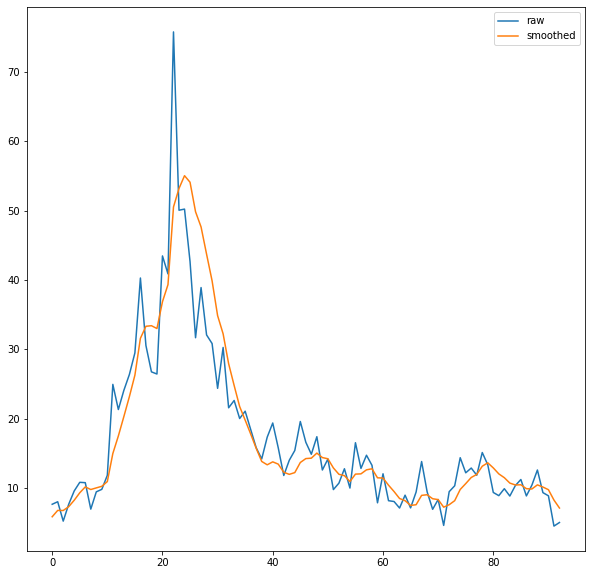

In [339]:
plt.figure(figsize=(10,10))
plt.plot(np.array(data_raw.value), label="raw")
plt.plot(np.array(data_smooth.value), label="smoothed")
plt.legend()

In [ ]:
# See here for pandas thing https://stackoverflow.com/questions/28417293/sample-datasets-in-pandas.
import pandas as pd
flights = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/flights.csv')
flights = flights.drop(index=1)
flights
flights.passengers.to_numpy()

Here we see the coefficients for a past window of length 14 (including the present) and polynomial degree 3. It is clear that most of the weight is on the most recent week of data, while the previous week's data acts as a counterweight.

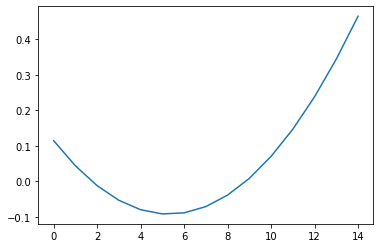

In [337]:
plt.plot(causal_savgol_coeffs(14, 3))

## Comparing Smoothing Methods
We compare the weighted local regression with the Savitzky-Golay (SG) method on a few signals. 

In the [Google Health Trends signal](https://github.com/cmu-delphi/delphi-epidata/blob/main/docs/api/covidcast-signals/ght.md) `ght`, we see that while the SG method is more noisy than the Gaussian-smoothed local regression (GSLR), it better matches the height, location, and width of the peaks.

Of course, the quality of the shape fit depends on the parameters chosen. Press et. al. suggest a heuristic: for a degree 4 polynomial, use a window length that is 1 to 2 times the FWHM (full width at half maximum) of the bumps.

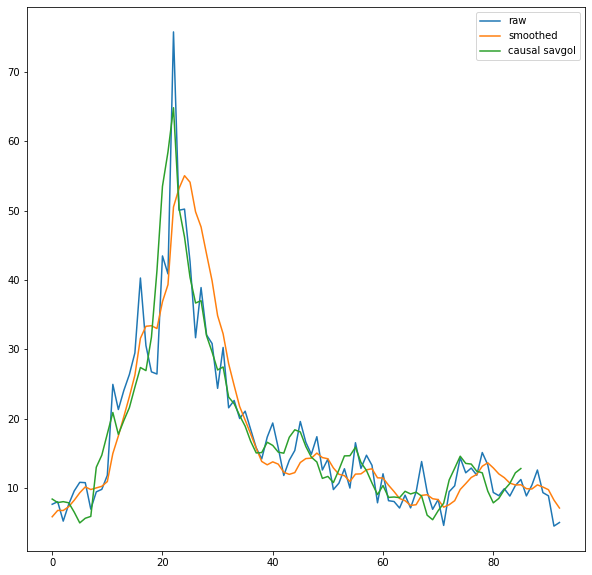

In [334]:
plt.figure(figsize=(10,10))
plt.plot(np.array(data_raw.value), label="raw")
plt.plot(np.array(data_smooth.value), label="smoothed")
# plt.plot(_left_gauss_linear(np.array(data_raw.value)), label="reproduced smoothed")
# plt.plot(np.hstack((savgol_filter(np.array(data_raw.value), 21, 5))), label="savgol")
plt.plot(causal_savgol_filter(np.array(data_raw.value), 14, 3), label="causal savgol")
plt.legend()

## Zero-censored Data
Suppose we randomly censor some small data points by setting them to zero. How well do the smoothers perform?

Here we see that the SG method can dip into the negatives, which is not great, but can be fixed by zero-thresholding. SG is also more sensitive to noise, so a larger window (4 weeks) helps. Reducing the degree down to 2 makes the method less noise-sensitive. However, the height of the peak isn't as well captured. 

Perhaps instead of zero-censoring, we can instead keep the last non-threshold value to reduce the size of the dips?

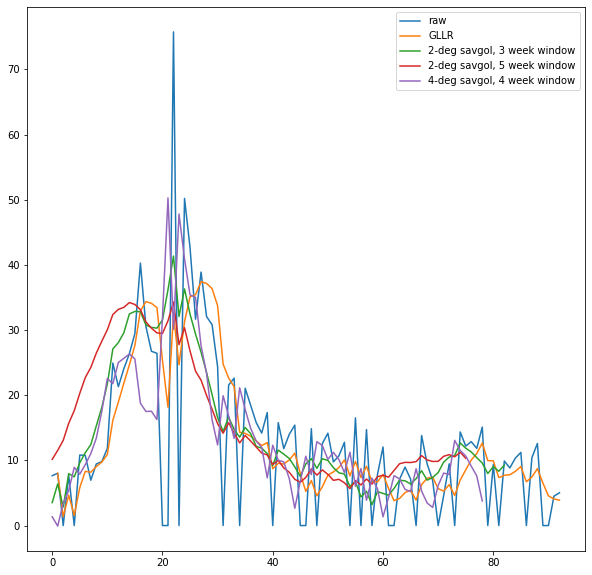

In [439]:
def _left_gauss_linear(s: np.ndarray, h=10, impute=False, minval=None) -> np.ndarray:
    """Local weighted least squares, where the weights are given by a Gaussian kernel.

    At each time t, we use the data from times 1, ..., t-dt, weighted
    using the Gaussian kernel, to produce the estimate at time t.

    Parameters
    ----------
    s: np.ndarray
        Input data.  Assumed to be ordered and on an equally spaced grid.
    h: float
        Bandwidth
    impute: bool
        Whether to set the fitted value at idx=0 to s[0].  (The local linear
        estimate is ill-defined for a single data point).
    minval: int
        Enforce a minimum value; for example, used for sensors which are
        nonnegative by definition.

    Returns
    -------
    np.ndarray
        the fitted values
    """

    assert h > 0, "Bandwidth must be positive"

    n = len(s)
    t = np.zeros_like(s, dtype=np.float64)
    X = np.vstack([np.ones(n), np.arange(n)]).T
    for idx in range(n):
        wts = np.exp(-((np.arange(idx + 1) - idx) ** 2) / (h ** 2))
        XwX = np.dot(X[: (idx + 1), :].T * wts, X[: (idx + 1), :])
        Xwy = np.dot(X[: (idx + 1), :].T * wts, s[: (idx + 1)].reshape(-1, 1))
        try:
            beta = np.linalg.solve(XwX, Xwy)
            t[idx] = np.dot(X[: (idx + 1), :], beta)[-1]
        except np.linalg.LinAlgError:
            # At idx 0, method will fail due to rank deficiency.
            t[idx] = s[idx] if impute else np.nan
    if minval is not None:
        t[t <= minval] = minval
    return t

def censor_data(x, n):
    """
    Randomly zero out n values from the array.
    """
    for i in range(n):
        ix = np.random.randint(len(x))
        x[ix] = 0
    return x

data_censored = censor_data(np.array(data_raw.value), 25)
plt.figure(figsize=(10,10))
plt.plot(data_censored, label="raw")
plt.plot(_left_gauss_linear(data_censored), label="GLLR")
plt.plot(causal_savgol_filter(data_censored, 21, 2), label="2-deg savgol, 3 week window")
plt.plot(causal_savgol_filter(data_censored, 35, 2), label="2-deg savgol, 5 week window")
plt.plot(causal_savgol_filter(data_censored, 28, 4), label="4-deg savgol, 4 week window")
plt.legend()

## Other Signals
The other signals had obstacles to a clear comparison.

The `doctor-visits` [signal](https://github.com/cmu-delphi/delphi-epidata/blob/main/docs/api/covidcast-signals/doctor-visits.md) seems to be an indicator already smoothed by the provider. The raw data does not appear to be available.

The `fb-survey` signal requires access to the survey data. 
> Individual survey responses are held by CMU and are sharable with other health researchers under a data use agreement.

The `google-survey` signal uses a similar smoothing procedure to `fb-survey`, which requries access to the underlying survey data. The results of applying smoothing to the already-estimated data is not great.

The `hospital-admissions` signal, like `doctor-surveys` comes already smoothed.

In [354]:
data_raw = covidcast.signal(data_source="doctor-visits", 
                            signal="raw_cli", 
                            start_day=None, 
                            end_day=None, 
                            geo_type="state", 
                            geo_values="ca")
data_smooth = covidcast.signal(data_source="doctor-visits", 
                            signal="smoothed_cli", 
                            start_day=None, 
                            end_day=None, 
                            geo_type="state", 
                            geo_values="ca")

In [ ]:
data_raw = covidcast.signal(data_source="fb-survey", 
                            signal="raw_cli", 
                            start_day=None, 
                            end_day=None, 
                            geo_type="state", 
                            geo_values="ca")
data_smooth = covidcast.signal(data_source="fb-survey", 
                            signal="smoothed_cli", 
                            start_day=None, 
                            end_day=None, 
                            geo_type="state", 
                            geo_values="ca")

In [363]:
data_raw = covidcast.signal(data_source="google-survey", 
                            signal="raw_cli", 
                            start_day=None, 
                            end_day=None, 
                            geo_type="state", 
                            geo_values="ca")
data_smooth = covidcast.signal(data_source="google-survey", 
                            signal="smoothed_cli", 
                            start_day=None, 
                            end_day=None,
                            geo_type="state", 
                            geo_values="ca")

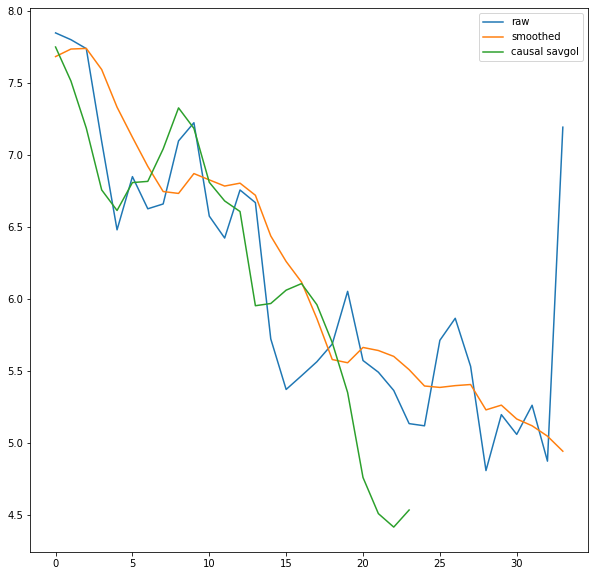

In [389]:
plt.figure(figsize=(10,10))
plt.plot(np.array(data_raw.value), label="raw")
plt.plot(np.array(data_smooth.value), label="smoothed")
plt.plot(causal_savgol_filter(np.array(data_raw.value), 21, 4), label="causal savgol")
plt.legend()

In [ ]:
data_raw = covidcast.signal(data_source="hospital-admissions", 
                            signal="raw_cli", 
                            start_day=None, 
                            end_day=None, 
                            geo_type="state", 
                            geo_values="ca")
data_smooth = covidcast.signal(data_source="hospital-admissions", 
                            signal="smoothed_cli", 
                            start_day=None, 
                            end_day=None,
                            geo_type="state", 
                            geo_values="ca")

In [392]:
data_raw = covidcast.signal(data_source="jhu-csse", 
                            signal="confirmed_incidence_num", 
                            start_day=None, 
                            end_day=None, 
                            geo_type="state", 
                            geo_values="ca")
data_smooth = covidcast.signal(data_source="jhu-csse", 
                            signal="deaths_incidence_num", 
                            start_day=None, 
                            end_day=None,
                            geo_type="state", 
                            geo_values="ca")

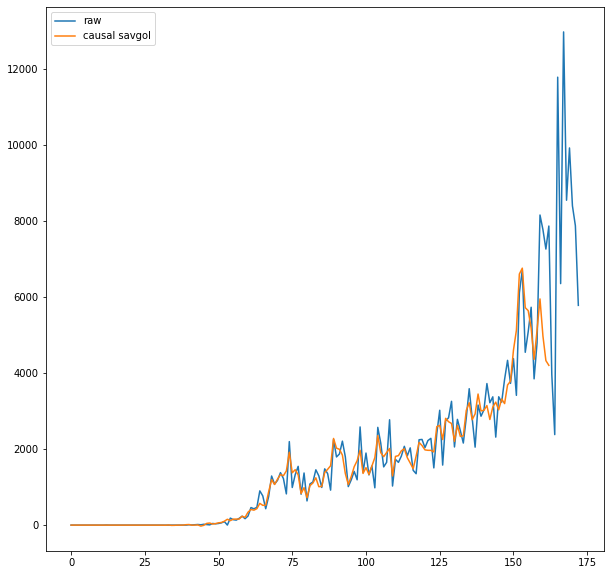

In [397]:
plt.figure(figsize=(10,10))
plt.plot(np.array(data_raw.value), label="raw")
plt.plot(causal_savgol_filter(np.array(data_raw.value), 21, 4), label="causal savgol")
plt.legend()